# Machine Learning in Crowd Modelling and Simulation

In this task we implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from visualization import visualize_state
from utilities import scenario_loader, scenario_builder

%reload_ext autoreload
%autoreload 2

## Task 1

We will implement the basics of our environment and show the outlook in this section.
First, if you wish to provide your own scenario then press no on the following cell block. Otherwise press yes and carry on.

Do you want to load a scenario? (y/n)n
Enter the size of the grid in the format: rows, columns: 10,10


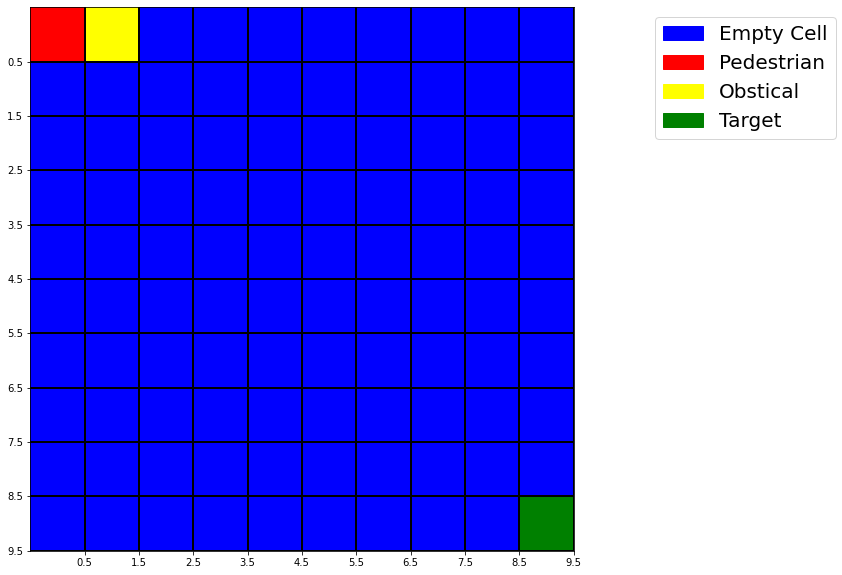

In [12]:
load_scenario_bool = input("Do you want to load a scenario? (y/n)")
    # Case if the user wishes to load a scenario saved in the scenario directory.
if load_scenario_bool == 'y':
    loaded_scenario = scenario_loader()
elif load_scenario_bool == 'n':
    custom_scneario = scenario_builder()

## Task 2

### Initial Visualization of scenario for Task 2

['task_1.csv']

## Task 3

## Task 4

## Task 5